In [1]:
!trash-empty

In [2]:
!nvidia-smi

Mon Nov  4 16:07:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    37W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import sys
package_path = 'EfficientNet-PyTorch/'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet
from radam import RAdam, PlainRAdam, AdamW
#from am_softmax import AMSoftmaxLoss, AngleSimpleLinear

In [5]:
import os
import gc
import pydicom
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

import cv2
import fastai
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback

from albumentations import (
    Compose, RandomRotate90, HorizontalFlip, VerticalFlip, Rotate, ShiftScaleRotate, Transpose,
    Normalize, RandomScale, CenterCrop, RandomGamma, GridDistortion,
    IAAPerspective, JpegCompression, ToGray, ChannelShuffle, RGBShift, CLAHE,
    RandomBrightnessContrast, RandomSunFlare, Cutout, OneOf, Resize
)
from albumentations.pytorch import ToTensor

import pretrainedmodels
print(pretrainedmodels.model_names)

import warnings
warnings.filterwarnings('ignore')

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


## Config

In [6]:
config = {
    'SEED': 42,
    'CLASSES': 6,
    'CHANNELS': 3,
    'PATH_DATA': 'data/',
    'PATH_WEIGHTS': '/home/jupyter/Nikita/',
    'DEVICE': 'cuda',
    'BATCH_SIZE': 12,
    'IMG_SIZE': 512,
    'NUM_WORKERS_ON_MACHINE': 8,
    'VAL_SIZE': 0.20,
    'MODEL_NAME': 'EffnetB5-fp16-HardAugs-FineTuning-PL2',
    'USE_ANGULAR': False,
    'USE_BN': False,
    'TrainTA': True,
    'TestTA': True,
    'LR': 1e-5,
    'LR_STR': '1e-5',
    'TURN_OFF_ON_N_EPOCHS': 0,
}

In [7]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
seed_torch(config['SEED'])

## Data

In [8]:
df = pd.read_csv(config['PATH_DATA']+'stage_1_train.csv')
train_features = pd.read_feather(config['PATH_DATA'] + 'df_trn.fth').dropna(subset=['img_pct_window'])
train_labels = pd.read_feather(config['PATH_DATA'] + 'labels.fth')

print(df.shape)
print(df['Label'].value_counts(normalize=True))

(4045572, 2)
0    0.942947
1    0.057053
Name: Label, dtype: float64


In [ ]:
comb = train_features.join(train_labels.set_index('ID'), 'SOPInstanceUID')
print(comb.shape)

comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)
print(comb.shape)

In [ ]:
comb.head()

In [9]:
newtable = df.copy()
new = newtable["ID"].str.split("_", n = 1, expand = True)
newX = new[1].str.split("_", n = 1, expand = True)
newtable['Image_ID'] = newX[0]
newtable['Sub_type'] = newX[1]

image_ids = newtable.Image_ID.unique()
train_df = pd.DataFrame(np.array([image_ids, np.zeros(len(image_ids))]).transpose(), columns=["id", "labels"])
labels = {i : "" for i in image_ids}

newtable = newtable[newtable.Label == 1]
for name, group in newtable.groupby("Image_ID"):
    labels[name] = " ".join(group.Sub_type)
    
train_df = pd.DataFrame(np.array([list(labels.keys()), list(labels.values())]).transpose(), columns=["id", "labels"])
train_df.id = "ID_" + train_df.id 

train_df = train_df.merge(comb, left_on='id', right_on='SOPInstanceUID', how='right')
train_df.id += ".dcm"

# train_df['labels'].hist(bins=len(train_df.labels.unique()), figsize=[12,6], xrot=90)
print(train_df.shape)
print(train_df['labels'].value_counts(normalize=True))

del new, newX, newtable, labels, df, train_features, train_labels, comb
gc.collect();

(674258, 44)
                                                                        0.855985
subdural any                                                            0.042875
subarachnoid any                                                        0.021827
intraparenchymal any                                                    0.020663
intraventricular any                                                    0.013220
intraparenchymal intraventricular any                                   0.009388
subarachnoid subdural any                                               0.006902
intraparenchymal subarachnoid any                                       0.005356
intraventricular subarachnoid any                                       0.004785
intraparenchymal subdural any                                           0.004378
intraparenchymal subarachnoid subdural any                              0.002991
intraparenchymal intraventricular subarachnoid any                      0.002612
epidural any   

In [10]:
broken_images = ['ID_6431af929.dcm']
broken_indexes = [train_df[train_df.id == i].index for i in broken_images]
train_df.drop(train_df.index[broken_indexes], inplace=True)

In [11]:
train_df.head(2)

,id,labels,BitsAllocated,BitsStored,Columns,HighBit,ImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,...,WindowCenter,WindowCenter1,WindowWidth,WindowWidth1,fname,img_max,img_mean,img_min,img_pct_window,img_std
0,ID_63eb1e259.dcm,,16,12,512,11,1.0,0.0,0.0,0.0,...,36.0,36.0,80.0,80.0,/home/jhoward/data/rsna/stage_1_train_images/I...,2465,544.463779,6,0.217003,650.349965
1,ID_2669954a7.dcm,,16,12,512,11,1.0,0.0,0.0,0.0,...,47.0,47.0,80.0,80.0,/home/jhoward/data/rsna/stage_1_train_images/I...,3788,438.149899,0,0.186054,550.336298


In [12]:
group_splitter = GroupShuffleSplit(test_size=config['VAL_SIZE'], n_splits=2, random_state=config['SEED'])
train_inds, val_inds = next(group_splitter.split(train_df, groups=train_df['PatientID']))  # StudyInstanceUID
train_subset, val_subset = train_df.iloc[train_inds], train_df.iloc[val_inds]

train_subset['is_valid'] = False
val_subset['is_valid'] = True
train_df = train_subset.append(val_subset)
train_df = train_df[['id', 'labels', 'is_valid']]

## Pseudo labels

In [13]:
!ls data/stage_1_test_images | tail -n 10

ID_fffaebafd.dcm
ID_fffb5a405.dcm
ID_fffbaa597.dcm
ID_fffc7d887.dcm
ID_fffcb2560.dcm
ID_fffe2edb8.dcm
ID_ffff3212e.dcm
ID_ffff59a97.dcm
ID_ffffb670a.dcm
ID_ffffcbff8.dcm


In [14]:
submission = pd.read_csv(config['PATH_DATA']+"stage_1_sample_submission.csv")

fold_fname_with_tta_d4 = 'predictions/{0}_{1}fold_{2}_lr{3}_TTA_D4.npy'
preds_b2_fold0_tta = np.load(fold_fname_with_tta_d4.format('EffnetB2-Adam-fp16-AppianWindows-HardAugs', 0, 5, '1e-4'))
preds_b2_fold1_tta = np.load(fold_fname_with_tta_d4.format('EffnetB2-Adam-fp16-AppianWindows-HardAugs', 1, 5, '1e-4'))
preds_b2_fold2_tta = np.load(fold_fname_with_tta_d4.format('EffnetB2-Adam-fp16-AppianWindows-HardAugs', 2, 5, '1e-4'))
preds_b2_fold3_tta = np.load(fold_fname_with_tta_d4.format('EffnetB2-Adam-fp16-AppianWindows-HardAugs', 3, 5, '1e-4'))
preds_b2_fold4_tta = np.load(fold_fname_with_tta_d4.format('EffnetB2-Adam-fp16-AppianWindows-HardAugs', 4, 5, '1e-4'))

In [15]:
preds = (preds_b2_fold0_tta + preds_b2_fold1_tta + preds_b2_fold2_tta + preds_b2_fold3_tta + preds_b2_fold4_tta) / 5
submission.Label = np.roll(preds, -1, axis=1).reshape(-1)

In [16]:
submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.000055
1,ID_28fbab7eb_intraparenchymal,0.000062
2,ID_28fbab7eb_intraventricular,0.000006
3,ID_28fbab7eb_subarachnoid,0.000287
4,ID_28fbab7eb_subdural,0.000477


In [17]:
submission.shape

(471270, 2)

In [18]:
submission[submission.Label > 0.90]

,ID,Label
52,ID_1dccedf60_subdural,0.926520
53,ID_1dccedf60_any,0.965299
140,ID_e9cbebf6a_intraventricular,0.967252
143,ID_e9cbebf6a_any,0.983760
235,ID_9c9fa5e90_intraparenchymal,0.996247
...,...,...
471137,ID_66f77666f_any,0.928842
471255,ID_5bc44227a_subarachnoid,0.993429
471257,ID_5bc44227a_any,0.997888
471261,ID_c76074a3c_subarachnoid,0.953455


In [19]:
submission[submission.Label > 0.80]

,ID,Label
35,ID_04e46d29f_any,0.867616
52,ID_1dccedf60_subdural,0.926520
53,ID_1dccedf60_any,0.965299
140,ID_e9cbebf6a_intraventricular,0.967252
143,ID_e9cbebf6a_any,0.983760
...,...,...
471137,ID_66f77666f_any,0.928842
471255,ID_5bc44227a_subarachnoid,0.993429
471257,ID_5bc44227a_any,0.997888
471261,ID_c76074a3c_subarachnoid,0.953455


In [20]:
submission[submission.Label > 0.70]

,ID,Label
35,ID_04e46d29f_any,0.867616
52,ID_1dccedf60_subdural,0.926520
53,ID_1dccedf60_any,0.965299
140,ID_e9cbebf6a_intraventricular,0.967252
143,ID_e9cbebf6a_any,0.983760
...,...,...
471137,ID_66f77666f_any,0.928842
471255,ID_5bc44227a_subarachnoid,0.993429
471257,ID_5bc44227a_any,0.997888
471261,ID_c76074a3c_subarachnoid,0.953455


In [21]:
pseudo_labels = submission[submission.Label > 0.90]
pseudo_labels_list = list(set(['data/stage_1_test_images/'+'_'.join(p.split("_")[:2])+'.dcm' for p in pseudo_labels.ID.values]))
print(len(pseudo_labels_list))

7395


In [22]:
pseudo_labels_list[:5]

['data/stage_1_test_images/ID_73cc3679e.dcm',
 'data/stage_1_test_images/ID_c41c00d20.dcm',
 'data/stage_1_test_images/ID_240131f24.dcm',
 'data/stage_1_test_images/ID_869d9a065.dcm',
 'data/stage_1_test_images/ID_1dd7a59a3.dcm']

In [23]:
with open('data/pseudo_labels.txt', 'w') as f:
    for item in pseudo_labels_list:
        f.write("%s\n" % item)

In [24]:
# !for file in `cat data/pseudo_labels.txt`; do cp "$file" data/stage_1_train_images/ ; done

In [25]:
pseudo_labels.head(2)

,ID,Label
52,ID_1dccedf60_subdural,0.926520
53,ID_1dccedf60_any,0.965299


In [26]:
# WORK WITH PL ONLY
pseudo_labels['labels'] = pseudo_labels["ID"].str.split("_", n=2, expand=True)[2]
pseudo_labels['id'] = pseudo_labels["ID"].str.split("_", n=2, expand=True)[0] + '_' + \
                        pseudo_labels["ID"].str.split("_", n=2, expand=True)[1] + '.dcm'

pseudo_labels.head(2)

,ID,Label,labels,id
52,ID_1dccedf60_subdural,0.926520,subdural,ID_1dccedf60.dcm
53,ID_1dccedf60_any,0.965299,any,ID_1dccedf60.dcm


In [27]:
pseudo_labels_df = pseudo_labels.groupby('id').agg({'labels': lambda x: ' '.join(x)}).reset_index()
pseudo_labels_df['is_valid'] = False

pseudo_labels_df.head(2)

,id,labels,is_valid
0,ID_000dcad55.dcm,any,False
1,ID_000edbf38.dcm,epidural any,False


In [28]:
print(len(train_df))
train_df = train_df.append(pseudo_labels_df)
print(len(train_df))

674257
681652


## Preprocessing

In [29]:
# https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(img, window_center,window_width, intercept, slope):
    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return (img - img_min) / (img_max - img_min)

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

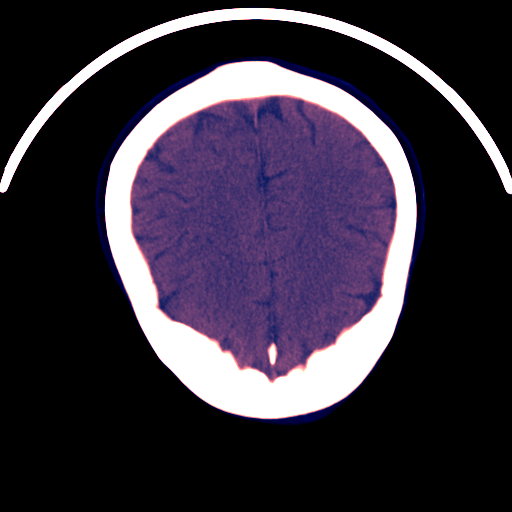

In [30]:
all_transforms = Compose([
    Resize(config['IMG_SIZE'], config['IMG_SIZE'], p=1.0),
    HorizontalFlip(),
    VerticalFlip(),
    RandomRotate90(),
    ShiftScaleRotate(scale_limit=0.1, rotate_limit=45),
    GridDistortion(num_steps=5, distort_limit=[-0.3,0.3], interpolation=1, border_mode=4),
    RandomGamma(gamma_limit=[80,120]),
    # ToTensor()
])

# https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/110728#latest-642755
def new_open_image(path, div=True, convert_mode=None, after_open=None):
    dcm = pydicom.dcmread(str(path))
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    intercept, slope = get_windowing(dcm)
    pixel_array = dcm.pixel_array.astype(np.int16) # "uint8"
    im_1 = window_image(pixel_array, 40, 80, intercept, slope) # brain
    im_2 = window_image(pixel_array, 80, 200, intercept, slope) # subdural
    im_3 = window_image(pixel_array, 40, 380, intercept, slope) # bone
    im = np.stack((im_1, im_2, im_3), axis=-1)
    
    if config['TrainTA']:
        transformed_im = all_transforms(image=im)['image']
        x = pil2tensor(transformed_im, dtype=np.float32)
    else:
        x = pil2tensor(im, dtype=np.float32)
        
    return Image(x)

vision.data.open_image = new_open_image
tmp = new_open_image('data/stage_1_train_images/ID_63eb1e259.dcm')
tmp

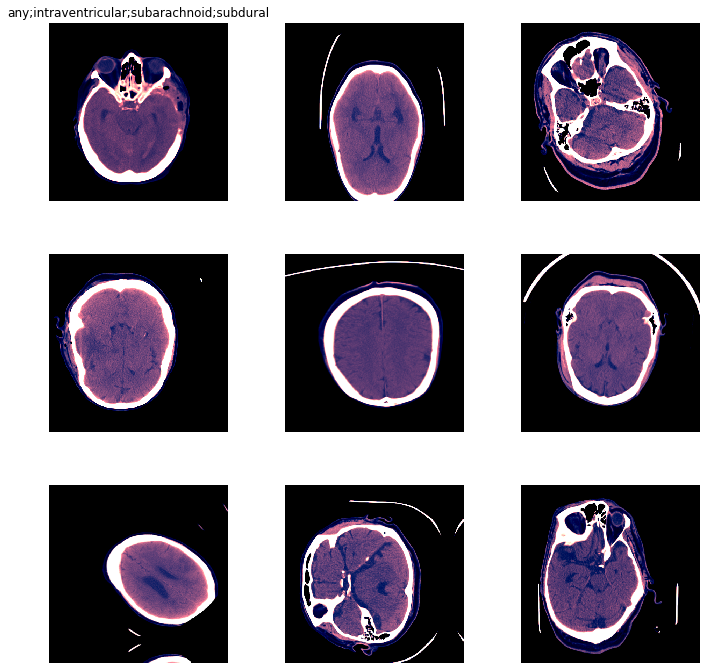

In [31]:
im_list = ImageList.from_df(train_df, path=config['PATH_DATA']+"stage_1_train_images")
data = (im_list.split_from_df()
               .label_from_df(label_delim=" ")
               .databunch(bs=config['BATCH_SIZE'], num_workers=config['NUM_WORKERS_ON_MACHINE'])
               .normalize(imagenet_stats))

data.show_batch(3, figsize=(10,10))

## Model

In [32]:
def get_effnet_model(model_version=0, num_classes=1000, num_channels=3,
                     pretrained=True, use_bn=False, use_angular=False):
    if pretrained:
        preloaded = EfficientNet.from_pretrained('efficientnet-b{}'.format(model_version), num_classes=num_classes)
    else:
        preloaded = None
    #print(preloaded)
    
    if use_bn:
        preloaded = nn.Sequential(OrderedDict([
                        ('norm0', nn.BatchNorm2d(num_channels)),
                        ('model', preloaded)]))
        model = preloaded.model
    else:
        model = preloaded
    
    if num_channels != 3:
        trained_kernel = model._conv_stem.weight
        new_conv = Conv2dStaticSamePadding(num_channels, 48,
                                           kernel_size=(3,3), stride=(2,2), bias=False,
                                           image_size=config['IMG_SIZE'])
        with torch.no_grad():
            new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*num_channels, dim=1)
        model._conv_stem = new_conv
            
    fc_input_features = model._fc.in_features
    if use_angular:
        model._fc = AngleSimpleLinear(fc_input_features, num_classes)
    else:
        model._fc = nn.Linear(fc_input_features, num_classes, bias=True)
    
    return preloaded

In [33]:
model = get_effnet_model(model_version=5,
                         num_classes=config['CLASSES'],
                         num_channels=config['CHANNELS'],
                         use_bn=config['USE_BN'],
                         use_angular=config['USE_ANGULAR'])
model.to(config['DEVICE']);

Loaded pretrained weights for efficientnet-b5


## Learner

In [34]:
data.classes

['any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [36]:
#!git clone https://github.com/fastai/fastai_dev.git
from fastai_dev.fastai2.basics import BaseLoss

# because target='any' is the 1th column in y_true
labels_weight = torch.tensor([2.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(config['DEVICE'])
loss = BaseLoss(nn.BCEWithLogitsLoss,
                pos_weight=labels_weight, floatify=True, flatten=False,  # weight=labels_weight
                is_2d=False, activation=torch.sigmoid)

learn = Learner(data=data,
                model=model,
                loss_func=loss,
                opt_func=partial(RAdam, weight_decay=1e-4),
                callback_fns=ShowGraph).to_fp16()
# learn.model = nn.DataParallel(learn.model)
learn.path = Path(config['MODEL_NAME'])
checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME'],
                                        every='epoch', monitor='valid_loss')

---

Model EffnetB5-fp16-HardAugs-FineTuning-PL2_4 not found.


epoch,train_loss,valid_loss,time
5,0.069158,0.071862,5:32:22


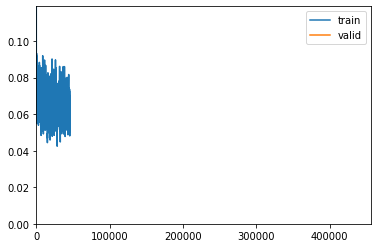

In [ ]:
best_epoch = 4
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], 'EffnetB5-fp16-HardAugs', best_epoch))

learn.unfreeze()
learn.fit_one_cycle(
    10,
    max_lr=config['LR'],
    callbacks=[checkpoint_callback],
    start_epoch=best_epoch+1,
)

## PAY ATTENTION! DANGEROUS!
## BICYCLE D4 TTA CODE BELOW! :)

In [37]:
from albumentations import DualTransform

class Rotate90(DualTransform):
    def apply(self, img, factor=1, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()
    
class Rotate180(DualTransform):
    def apply(self, img, factor=2, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()
    
class Rotate270(DualTransform):
    def apply(self, img, factor=3, **params):
        """
        Args:
            factor (int): number of times the input will be rotated by 90 degrees.
        """
        return np.ascontiguousarray(np.rot90(img, factor))

    def get_transform_init_args_names(self):
        return ()

In [38]:
def change_open_image_function(tta_index):
    resize_transform = Resize(config['IMG_SIZE'], config['IMG_SIZE'], p=1.0)
    
    def new_open_image(path, div=True, convert_mode=None, after_open=None):
        dcm = pydicom.dcmread(str(path))
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            correct_dcm(dcm)
        intercept, slope = get_windowing(dcm)
        pixel_array = dcm.pixel_array.astype(np.int16) # "uint8"
        im_1 = window_image(pixel_array, 40, 80, intercept, slope) # brain
        im_2 = window_image(pixel_array, 80, 200, intercept, slope) # subdural
        im_3 = window_image(pixel_array, 40, 380, intercept, slope) # bone
        im = np.stack((im_1, im_2, im_3), axis=-1)
        
        if tta_index == 0:
            tta_transforms = Compose([resize_transform])
        elif tta_index == 1:
            tta_transforms = Compose([resize_transform, HorizontalFlip(p=1.0)])
        elif tta_index == 2:
            tta_transforms = Compose([resize_transform, VerticalFlip(p=1.0)])
        elif tta_index == 3:
            tta_transforms = Compose([resize_transform, Rotate90(p=1.0)])
        elif tta_index == 4:
            tta_transforms = Compose([resize_transform, Rotate180(p=1.0)])
        elif tta_index == 5:
            tta_transforms = Compose([resize_transform, Rotate270(p=1.0)])
        
        transformed_im = tta_transforms(image=im)['image']
        x = pil2tensor(transformed_im, dtype=np.float32)
        return Image(x)
    
    vision.data.open_image = new_open_image

----

In [39]:
best_epoch = 5
learn.load('{0}{1}/models/{1}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch))
submission = pd.read_csv(config['PATH_DATA']+"stage_1_sample_submission.csv")
test_fnames = submission["ID"].str.split("_", n=2, expand=True)[1].unique()
test_fnames = pd.DataFrame("ID_" + test_fnames + ".dcm")
test_im_list = ImageList.from_df(test_fnames, path=config['PATH_DATA']+"stage_1_test_images")
learn.data.add_test(test_im_list)

In [40]:
tta_preds = np.zeros((len(test_im_list), config['CLASSES']))

TTA = 6
for i in range(TTA):
    change_open_image_function(i)
    preds = learn.get_preds(ds_type=DatasetType.Test)
    preds = preds[0].numpy()
    tta_preds += preds / TTA
    print(preds.shape)
    print('TTA #{} completed'.format(i))
    
np.save('predictions/{0}_{1}_lr{2}_TTA_D4.npy'.format(config['MODEL_NAME'], best_epoch, config['LR_STR']),
        tta_preds)

(78545, 6)
TTA #5 completed


In [41]:
print('EPOCH #{} TTA D4'.format(best_epoch))
submission.Label = np.roll(tta_preds, -1, axis=1).reshape(-1)
submission.to_csv("submits/{0}_{1}_lr{2}_TTA_D4.csv".format(config['MODEL_NAME'], best_epoch, config['LR_STR']), index=False)
# submission['Label'].hist(bins=100, figsize=[12,6], xrot=90)
submission['htype'] = submission["ID"].str.split("_", n=2, expand=True)[2]
submission.groupby('htype').mean().head(6)

EPOCH #5 TTA D4


,Label
htype,
any,0.150021
epidural,0.004893
intraparenchymal,0.039078
intraventricular,0.028557
subarachnoid,0.039412
subdural,0.049637
